In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import imageio.v2 as imageio
from tqdm import tqdm

%matplotlib inline

In [4]:
m1 = torch.tensor([4, -4., 0])
m2 = torch.tensor([0., 0., -4.])
t = torch.tensor([.1])
dt = 0.01
sigma = torch.tensor([3.])
min_val = -6
max_val = 6

In [5]:
def calc_logsumexp(x, denom):
    return torch.exp(x - torch.logsumexp(denom, dim=0))


def compute_S_i_t(x, t, m1, m2, Gamma_t, label=None, omega=None):
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(-m1 * m2 * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(m1 * m2 * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.dot(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.dot(x, (m1 - m2))

    arg1 = torch.log(exp_neg_m1m2) + x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg2 = torch.log(exp_neg_m1m2) - x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg3 = torch.log(exp_pos_m1m2) + x_dot_m1_minus_m2 * exp_neg_t / Gamma_t
    arg4 = torch.log(exp_pos_m1m2) - x_dot_m1_minus_m2 * exp_neg_t / Gamma_t

    denom = torch.stack([arg1, arg2, arg3, arg4], dim=0)
    l11 = (m1 + m2) * calc_logsumexp(arg1, denom)
    l12 = -(m1 + m2) * calc_logsumexp(arg2, denom)
    l21 = (m1 - m2) * calc_logsumexp(arg3, denom)
    l22 = - (m1 - m2) * calc_logsumexp(arg4, denom)

    S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (l11 + l12 + l21 + l22)
    return S_i_t

In [6]:
def get_vf(m1, m2, score_func, t, dt, sigma, n=10, min=-5, max=5, label=0, plot=False, omega=None, l=0.5, elev=45, azim=45,):
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    xx, yy, zz = torch.meshgrid(
        [torch.linspace(min, max, steps=n)]*3, indexing='ij')
    inp = torch.stack((xx, yy, zz), dim=-1).reshape(-1, 3)
    conc = []
    for inp_ in inp:
        conc.append(score_func(inp_, t, m1, m2, Gamma_t, label=label, omega=omega))

    conc = torch.stack(conc).detach().numpy()
    inp = inp.detach().numpy()

    if plot:
        ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
        ax.quiver(inp[:, 0], inp[:, 1], inp[:, 2], conc[:, 0],
                  conc[:, 1], conc[:, 2], length=l, normalize=True, alpha=0.5)
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            ax.scatter(plots[0], plots[1], plots[2], color='r', s=100)
        # Adjust these values to rotate the plot
        ax.view_init(elev=elev, azim=azim)
        plt.suptitle("Time is t: "+str(round(t.item(), 2)))
        plt.tight_layout()
        plt.show()
    return inp, conc

In [7]:
def generate_gif(gifname, score_func, m1, m2, dt, sigma, min_val, max_val, label=None, omega=None, l=.75,  elev=45, azim=45,):
    images = []

    t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
    for t_value in tqdm(t_values):
        t = torch.tensor([t_value])
        inp, conc = get_vf(m1, m2, score_func, t, dt, sigma, n=10, min=min_val, max=max_val, label=label, omega=omega, l=l, elev=elev, azim=azim,)

        ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
        ax.quiver(inp[:,0], inp[:,1], inp[:,2], conc[:,0],conc[:,1], conc[:,2], length=.75, normalize=True, alpha=0.5)
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            ax.scatter(plots[0], plots[1], plots[2], color='r', s=100)
        ax.view_init(elev=30, azim=25)  # Adjust these values to rotate the plot
        plt.title(f't = {t_value:.2f}')
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.tight_layout()
        # Save the plot to a temporary file
        plt_path = f'temp_plots/temp_{t_value:.2f}.png'
        plt.savefig(plt_path)
        plt.close()
        

        images.append(imageio.imread(plt_path))

    imageio.mimsave('gifs/'+gifname+'_3d.gif', images, duration=0.05)

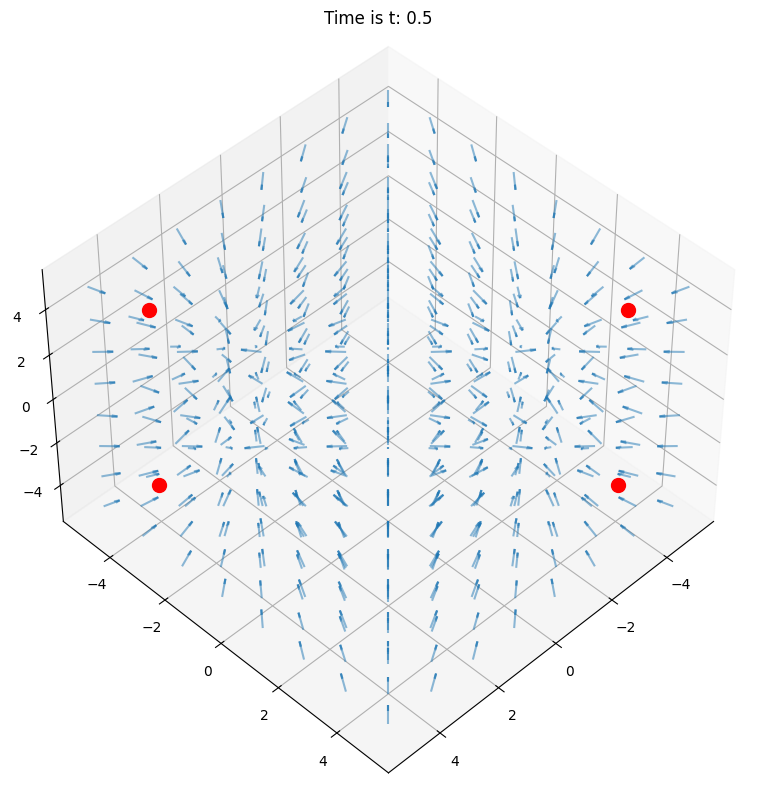

In [162]:
inp, conc = get_vf(m1, m2, compute_S_i_t, t, dt, sigma, n=8, min=-5, max=5, plot=True)

In [ ]:
generate_gif('uncond_score', compute_S_i_t, m1, m2, dt, sigma, min_val, max_val, l=.75, elev=30, azim=25)

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


## Only CFG part (true score)

In [8]:
def cond_score(x, t, m1, m2, Gamma_t, label=0, omega=None):
    score = (-x +((2*(label<2)-1) * m1 + (2*(label%2)-1) * m2) * torch.exp(-t)) / Gamma_t
    return 100*score

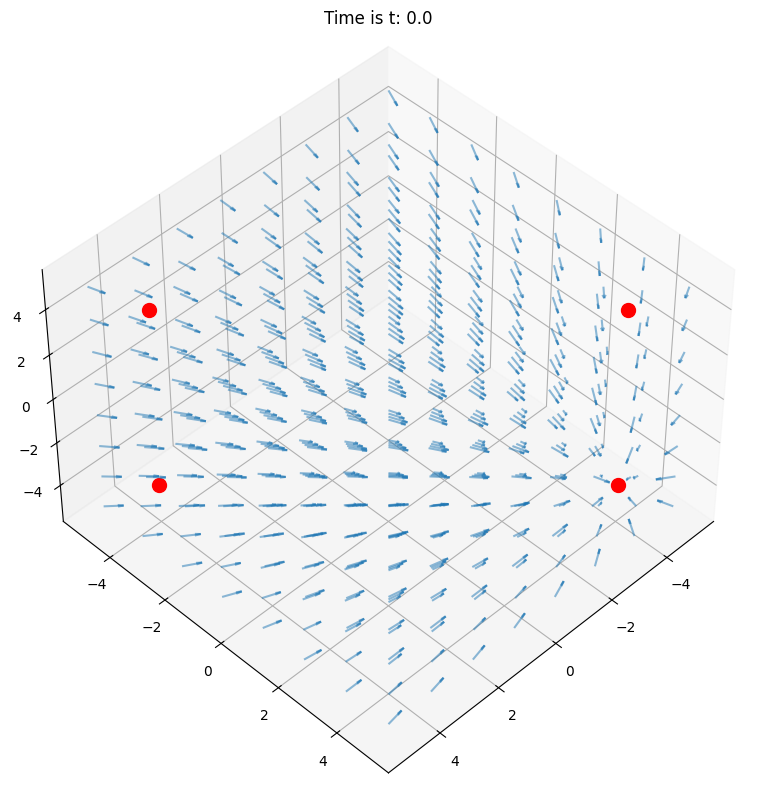

In [ ]:
inp, conc = get_vf(m1, m2, cond_score, t, dt, sigma, n=8, min=-5, max=5, plot=True, label=3)

In [177]:
generate_gif('cond_score', cond_score, m1, m2, dt, sigma, min_val, max_val, label=0, l=.75, elev=30, azim=25)

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


# CFG

In [ ]:
def cfg(x, t, m1, m2, Gamma_t, omega, label=0):
    uncond_score = compute_S_i_t(x, t, m1, m2, Gamma_t, label)
    cond_score_ = cond_score(x, t, m1, m2, Gamma_t, label)
    return (1+omega) * cond_score_ - omega * uncond_score

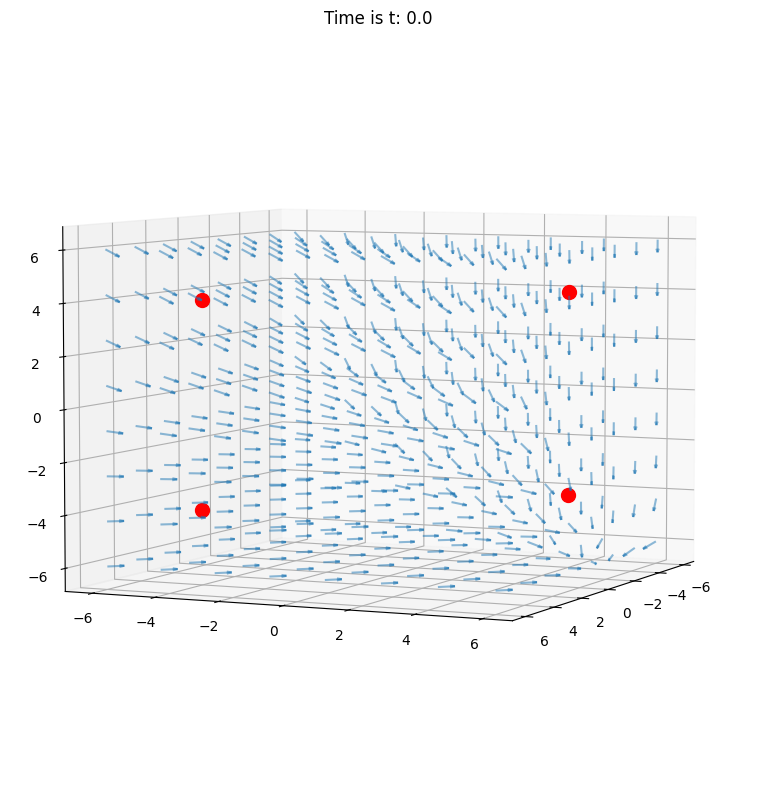

In [ ]:
inp, conc = get_vf(m1, m2, cfg, t, dt, sigma, omega=100., n=8, min=-6, max=6, plot=True, label=3, elev=5, azim=25)

In [188]:
generate_gif('cfg_score', cfg, m1, m2, dt, sigma, min_val, max_val, omega=1.5, label=0, l=.75, elev=30, azim=25)

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


In [ ]:
# add a plot of all three
# add the moving stuff
## check the moving for both forward and backward